# Primal-Dual Algorithm for Image Segmentation

In [5]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import pylops
from pyproximal.optimization.primaldual import *
# from pyproximal.optimization.segmentation import *
from scripts.Segment_ import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# data Loading

m_true = np.load('data/m_true.npy')
m1 = np.load('data/mpd3a.npy')
m2 = np.load('data/mpd3b.npy')
dif = m2 - m1

vmin, vmax =  m1.min(), m1.max()

## Example 1: Segmentation of time-lapse difference of subsurface models

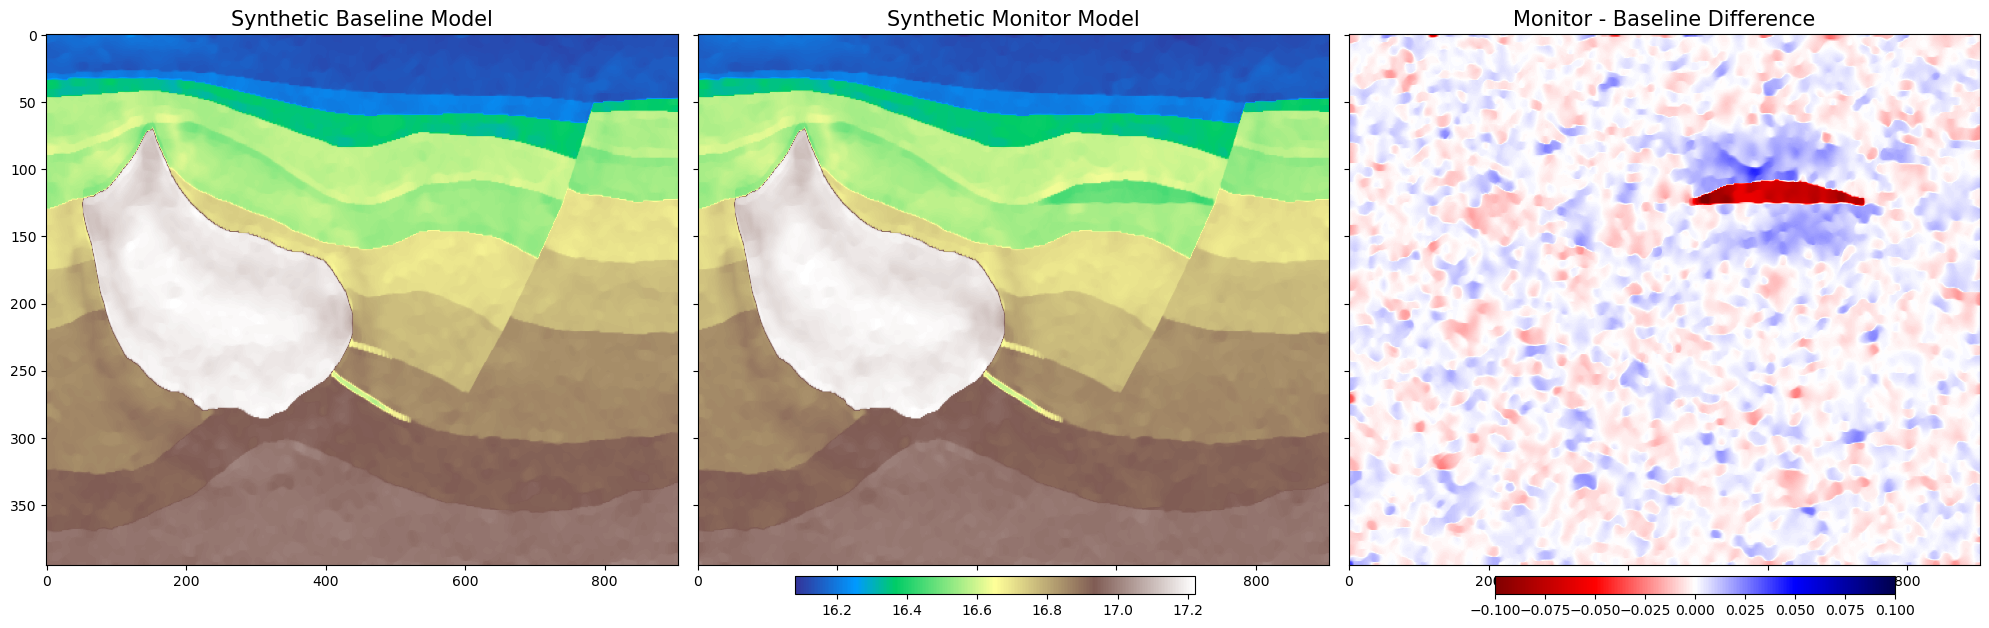

In [7]:
fig, ax = plt.subplots(1,3, figsize=(20,6), sharey=True)
ax = ax.flatten()
ax0 = ax[0].imshow(m1, vmin=vmin,  vmax=vmax, cmap='terrain')
ax[0].set_title('Synthetic Baseline Model', fontsize=15)
ax[0].axis('tight');
ax[1].imshow(m2, vmin=vmin, vmax=vmax, cmap='terrain')
ax[1].set_title('Synthetic Monitor Model', fontsize=15)
ax[1].axis('tight');
ax2=ax[2].imshow(dif, vmin=-0.1, vmax=0.1, cmap='seismic_r')
ax[2].set_title('Monitor - Baseline Difference', fontsize=15)
ax[2].axis('tight');
fig.tight_layout()
fig.subplots_adjust(bottom=0.5)
cbar_ax = fig.add_axes([0.4, 0.001, 0.2, 0.03])
fig.colorbar(ax0, cax=cbar_ax, orientation='horizontal')
fig.subplots_adjust(bottom=0.05)
cbar_ax = fig.add_axes([0.75, 0.001, 0.2, 0.03])
fig.colorbar(ax2, cax=cbar_ax, orientation='horizontal')

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 50

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   3.33330e-01   0.000e+00   2.478e-02   3.121e+02       3.121e+02
     2   3.34627e-01   0.000e+00   4.667e-02   3.125e+02       3.126e+02
     3   3.35922e-01   0.000e+00   1.579e-01   3.100e+02       3.102e+02
     4   3.33308e-01   0.000e+00   1.347e-01   3.100e+02       3.101e+02
     5   3.34596e-01   0.000e+00   1.262e-01   3.104e+02       3.106e+02
     6   3.35881e-01   0.000e+00   1.392e-01   3.109e+02       3.110e+02
     7   3.33256e-01   0.000e+00   1.790e-01   3.081e+02       3.082e+02
     8

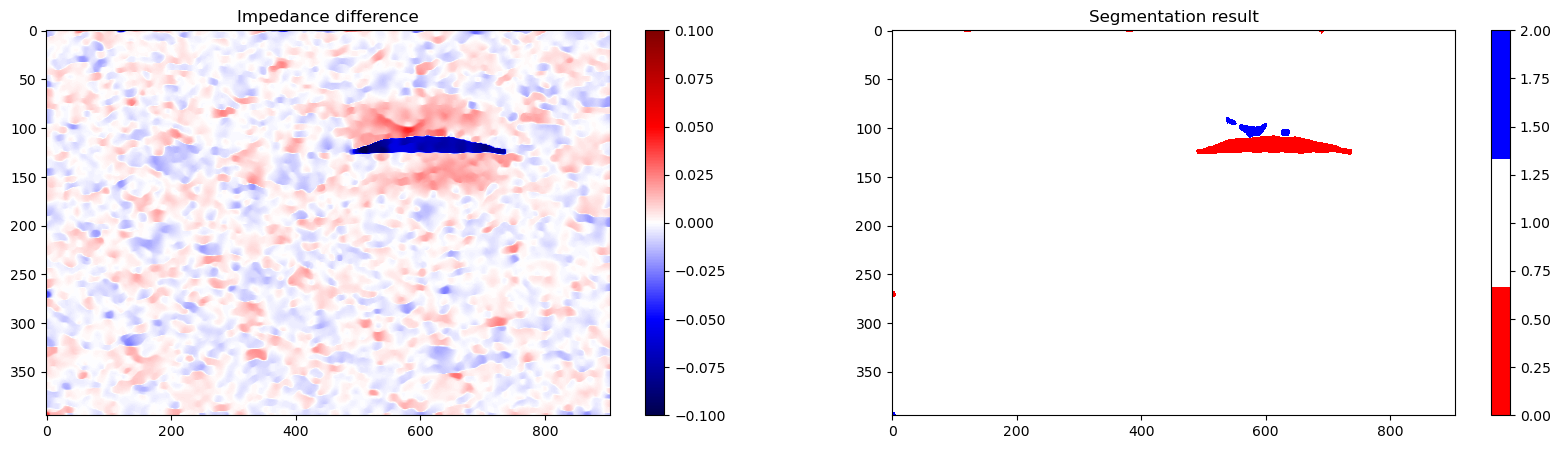

In [8]:
colors = [(1, 0, 0), (142, 142, 142), (0, 0, 1)] 
cmap = LinearSegmentedColormap.from_list('segm', colors, N=3)
cl    = np.array([-0.05,0, 0.05])
sigma = 1.
alpha = 0.001

segpd, segpd_classes = \
    Segment(dif, cl, sigma, alpha, niter=50, show=True, 
            kwargs_simplex=dict(engine='numba', maxiter=10, call=False))

fig, ax = plt.subplots(1,2, figsize=(20,5)) 
im0 = ax[0].imshow(dif, cmap='seismic', vmin = -0.1, vmax = 0.1)
ax[0].axis('tight');
ax[0].set_title('Impedance difference')   
im1 = ax[1].imshow(segpd_classes, cmap=cmap, vmin=0, vmax=2)
ax[1].axis('tight');
ax[1].set_title('Segmentation result') 
fig.colorbar(im0, ax=ax[0], orientation='vertical')
fig.colorbar(im1, ax=ax[1], orientation='vertical')
plt.show() 

## Example 2: Segmentation of subsurface model

In [9]:
allcl = np.unique(m_true)
nclmin = 3000 #10000
cl = np.array(list(filter(lambda x: np.count_nonzero(m_true.ravel() == x) > nclmin, allcl)))
ncl = len(cl)

segpd, segpd_classes = \
    Segment(m1, cl, 20., 0.2, niter=50, show=True, 
            kwargs_simplex=dict(engine='numba',  maxiter=10, call=False))


Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 50

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   4.25250e-01   0.000e+00   1.263e+03   2.527e+04       2.653e+04
     2   4.71547e-01   0.000e+00   1.475e+03   1.345e+04       1.492e+04
     3   4.55274e-01   0.000e+00   1.568e+03   9.200e+03       1.077e+04
     4   4.42810e-01   0.000e+00   1.617e+03   7.533e+03       9.150e+03
     5   4.26316e-01   0.000e+00   1.669e+03   6.767e+03       8.436e+03
     6   4.13590e-01   0.000e+00   1.722e+03   6.217e+03       7.939e+03
     7   3.96826e-01   0.000e+00   1.768e+03   5.786e+03       7.554e+03
     8

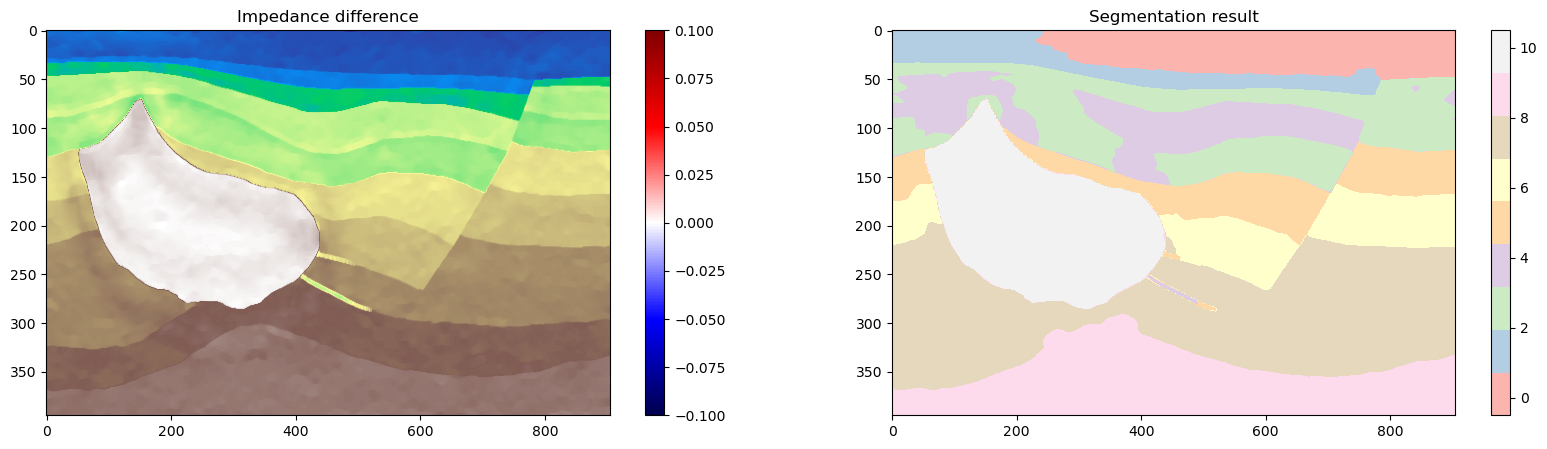

In [10]:
fig, ax = plt.subplots(1,2, figsize=(20,5)) 
ax0 = ax[0].imshow(m1, vmin=vmin,  vmax=vmax, cmap='terrain')
ax[0].axis('tight');
ax[0].set_title('Impedance difference')   
im1 = ax[1].imshow(segpd_classes, cmap='Pastel1', vmin=-0.5, vmax=ncl-0.5,)
ax[1].axis('tight');
ax[1].set_title('Segmentation result') 
fig.colorbar(im0, ax=ax[0], orientation='vertical')
fig.colorbar(im1, ax=ax[1], orientation='vertical')
plt.show() 